Note: by cropping here we loose some data (temporally), but we use the dataframe for window processing and need NaN-free series

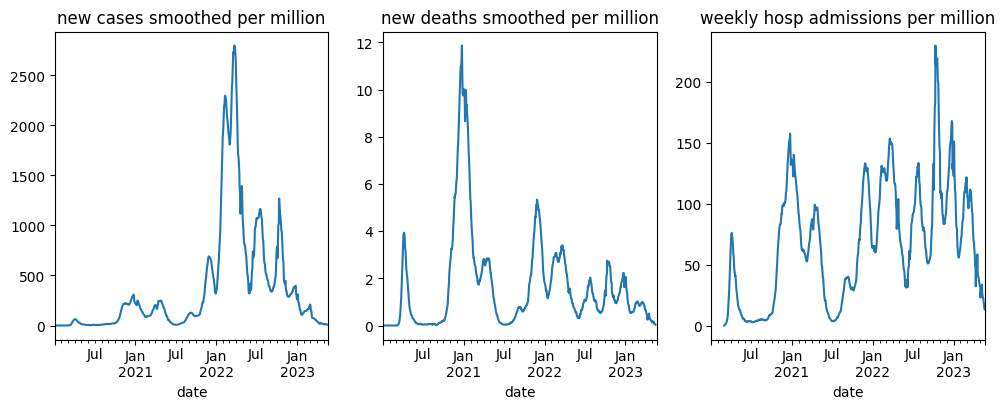

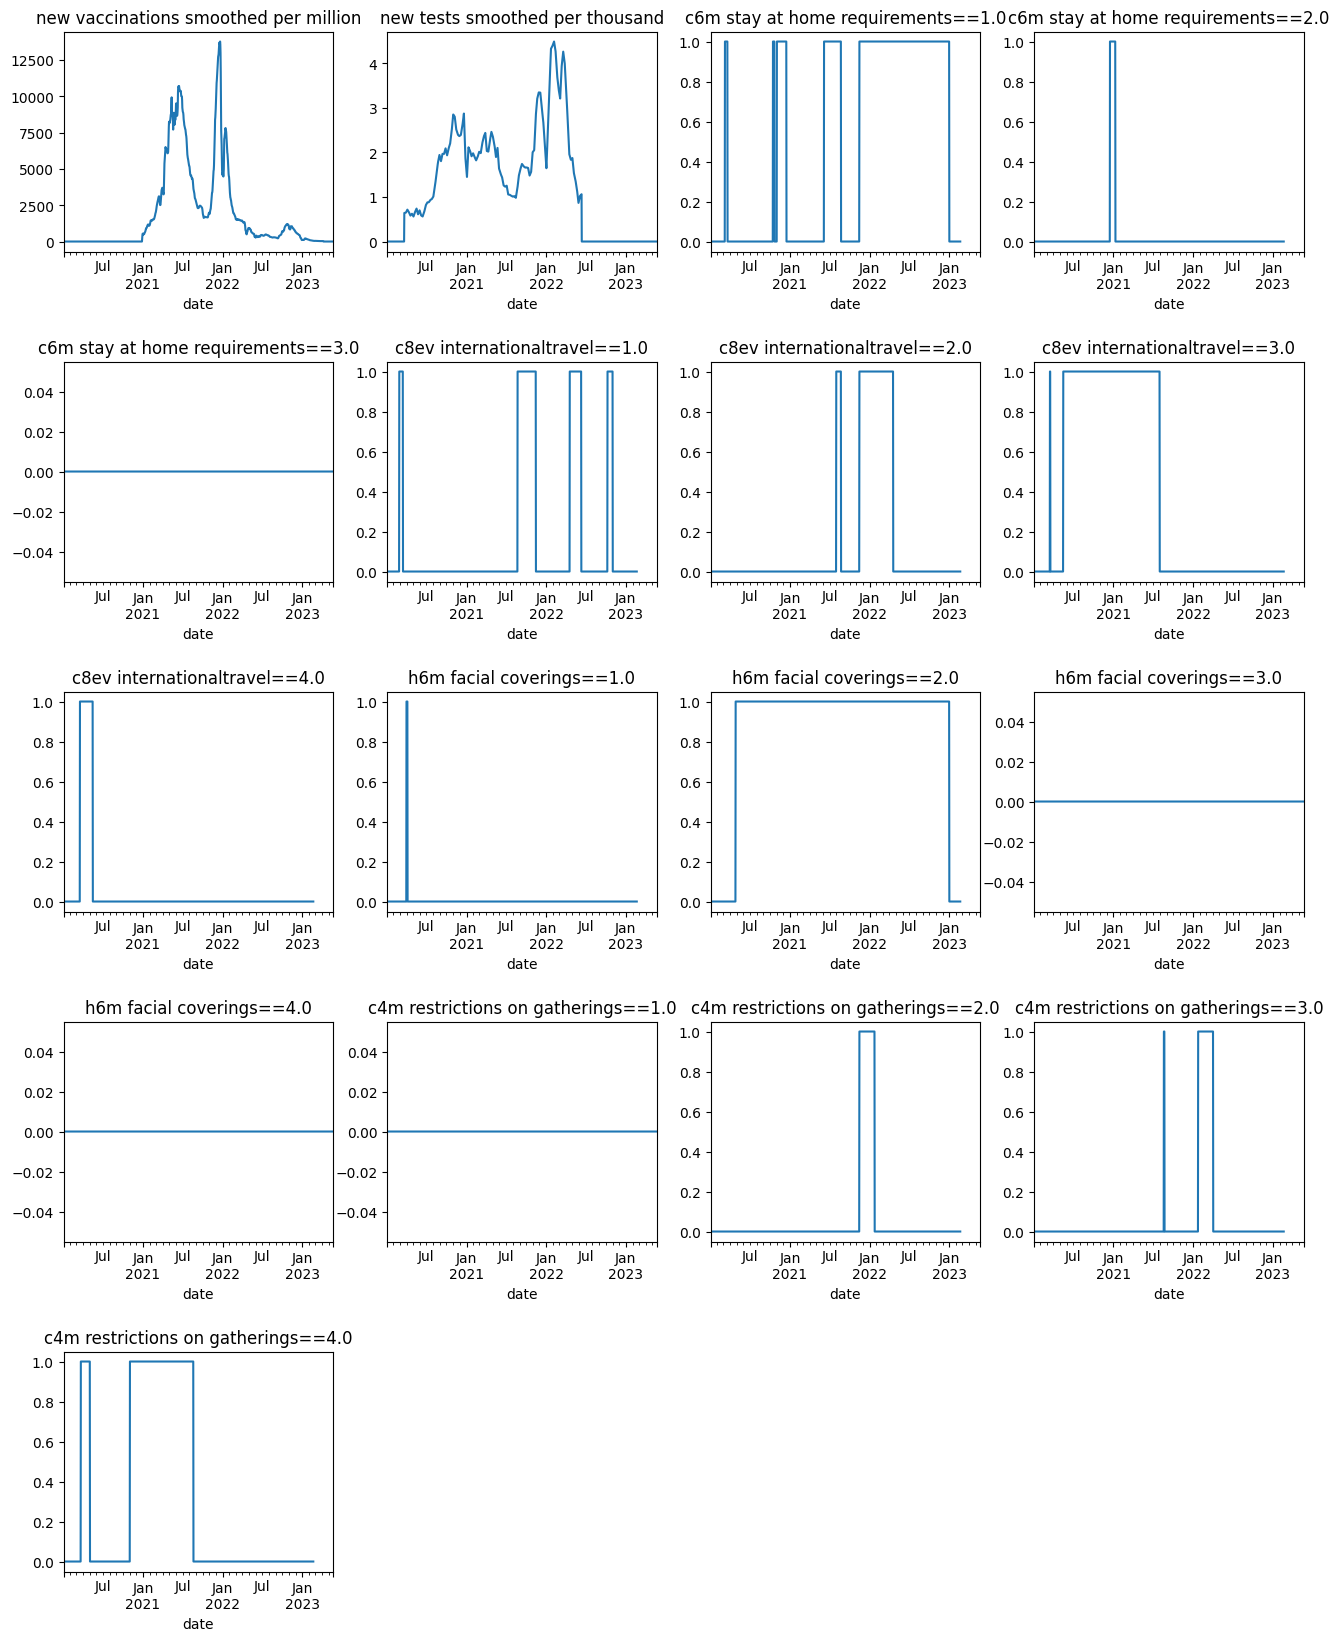

In [62]:
import require
import numpy as np
from IPython.display import Markdown as md
get_data_for_country = require.single( "get_data_for_country" )
crop_to_valid_range = require.single( "crop_to_valid_range" )

df = get_data_for_country( "Germany", verbose = True )
df = crop_to_valid_range( df ).copy( ) 

In [60]:
train_weak_learner = require.single( "train_weak_learner" )

In [61]:
# this produces a perfect-fit model for debugging
ensemble = [ ]
ensemble.append( train_weak_learner([ df ], length_l = 10, lag = 0, length_r = 10, linear_operator = np.identity( 10 )))

number of dataframes,1
samples from dataframe 0,1068
total number of samples,1068
number of time series,20
number of outcome series,3
length of left/predictor window,10
lag/spacing between windows,0
length of right/response window,10
shape of linear operator M,"(10, 10)"


### Theory
 Consider the predictor windows $L \in \mathbb{R}^{(1068, 10, 20)}$ and response windows $R \in \mathbb{R}^{(1068, 10, 3)}$. Let $X \in \mathbb{R}^{(1068, 200)}$ be a reshaping of $L$ which is directly passed into the model as predictor sample matrix. Let latent response $Z \in \mathbb{R}^{(1068, 30)}$ be a reshaping of $R$. As the name suggests, this is not given to the model. Instead, the model observes a linear transformation of $Z$: We have $Y \in \mathbb{R}^{(1068, 30)}=Z (M \otimes I_{3})^\top$. This applies the linear operator $M \in \mathbb{R}^{(10, 10)}$ to every outcome time series window. Hence, the weak learner learns a function $f: \mathbb{R}^{(10, 20)} \rightarrow \mathbb{R}^{(10, 3)}$, where $f(x)=y=Mz$

In [4]:
# this is a somewhat more realistic ensemble
ensemble = [ ]

for length_l, lag, length_r in zip([ 20, 10, 5 ], [ 30, 20, 10 ], [ 20, 10, 5 ]):

    mean = np.ones(( 1, length_r )) / length_r
    learner = train_weak_learner([ df ], length_l = length_l, lag = lag, length_r = length_r, linear_operator = mean )    
    ensemble.append( learner )

first_last = np.zeros(( 2, 10 ))
first_last[ 0, 0 ] = 1
first_last[ 1, length_r - 1 ] = 1
ensemble.append( train_weak_learner([ df ], length_l = 10, lag = 20, length_r = 10, linear_operator = first_last ))

In [5]:
# for predicted time range
min_start = max([ l.length_l + l.lag for l in ensemble ])
min_length = max([ l.length_r for l in ensemble ])

start = min_start
length = 800

assert start >= min_start
assert length >= min_length

lhs_chunks = [ ]
rhs_chunks = [ ]

for learner in ensemble:

    n_predictions = 1 + length - learner.length_r
    M = learner.linear_operator
    lag = learner.lag

    for i in range( n_predictions ):

        chunk = np.zeros(( M.shape[ 0 ], length ))
        chunk[ :, i : i + M.shape[ 1 ]] = M
        lhs_chunks.append( chunk )
        
        window = df.iloc[ start - lag - 1 + i : start - lag - 1 + i + learner.length_l, : ].to_numpy( )
        y = learner.predict( window )
        rhs_chunks.append( y )

lhs = np.concatenate( lhs_chunks, axis = 0 )
rhs = np.concatenate( rhs_chunks, axis = 0 )

assert lhs.shape == ( rhs.shape[ 0 ], length )

print( f"lhs shape = { lhs.shape }" )
print( f"lhs rank = { np.linalg.matrix_rank( lhs )}" )
print( f"degrees of freedom = { length }" )

lhs shape = (3950, 800)
lhs rank = 800
degrees of freedom = 800


In [6]:
prediction, *_ = np.linalg.lstsq( lhs, rhs, rcond = None )
print( prediction.shape )

(800, 3)


In [7]:
import matplotlib.pyplot as plt

new_cases_smoothed_per_million


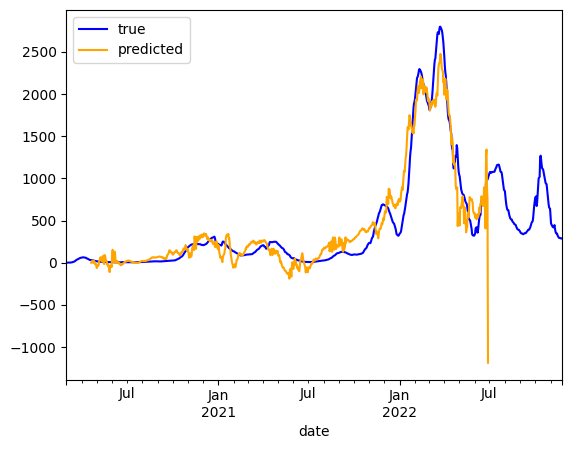

In [11]:
time_range = slice( 0, 1000 )
column = 0

df_pred = df.copy( )
df_pred.iloc[ :, : ] = np.nan
df_pred.iloc[ start : start + length, :3 ] = prediction
df.iloc[ time_range, column ].plot( color = "blue" )
df_pred.iloc[ time_range, column ].plot( color = "orange" )

line = lambda color, label: plt.Line2D([ ], [ ], color = color, label = label )
h = [ line( "blue", "true" ), line( "orange", "predicted" )]

plt.legend( handles = h )
print( df_pred.columns[ column ])

In [12]:
str = "### Theory\n"
str += f"Now, we have the sample data $L \in \mathbb{{R}}^{{{ L.shape }}}$ and $R \in \mathbb{{R}}^{{{ R.shape }}}$.\n\n"
str += f"Our weak learner should learn a function $x \mapsto y:=M z$ for $x \in \mathbb{{R}}^{{{ L.shape[ 1: ]}}}$, $z \in \mathbb{{R}}^{{{ R.shape[ 1: ]}}}$ and a linear operator $M$"
md( str )

### Theory
Now, we have the sample data $L \in \mathbb{R}^{(1096, 10, 20)}$ and $R \in \mathbb{R}^{(1096, 10, 3)}$.

Our weak learner should learn a function $x \mapsto y:=M z$ for $x \in \mathbb{R}^{(10, 20)}$, $z \in \mathbb{R}^{(10, 3)}$ and a linear operator $M$

### Learning
We flatten the sample data here for linear regression. This treats a window as a flat row vector.

$Z$ is hidden from the model to support regularization. We apply the mean to $Z$'s window time axis